In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm

pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
h5_path = os.path.join(notebook_dir,'alphaVantage vanillas.h5')
store = pd.HDFStore(h5_path)
store.close()

In [2]:
from historical_av_key_collector import keys_df
keys_df

,contract_key,raw_data_key,surface_key,calibration_key,priced_securities_key,date
0,/date_2024_10_09/hottest_contracts,/date_2024_10_09/raw_data,/date_2024_10_09/surface,/date_2024_10_09/calibration,/date_2024_10_09/priced_securities,2024-10-09
1,/date_2024_10_08/hottest_contracts,/date_2024_10_08/raw_data,/date_2024_10_08/surface,/date_2024_10_08/calibration,/date_2024_10_08/priced_securities,2024-10-08
2,/date_2024_10_07/hottest_contracts,/date_2024_10_07/raw_data,/date_2024_10_07/surface,/date_2024_10_07/calibration,/date_2024_10_07/priced_securities,2024-10-07
3,/date_2024_10_04/hottest_contracts,/date_2024_10_04/raw_data,/date_2024_10_04/surface,/date_2024_10_04/calibration,/date_2024_10_04/priced_securities,2024-10-04
4,/date_2024_10_03/hottest_contracts,/date_2024_10_03/raw_data,/date_2024_10_03/surface,/date_2024_10_03/calibration,/date_2024_10_03/priced_securities,2024-10-03
...,...,...,...,...,...,...
4194,/date_2008_01_08/hottest_contracts,/date_2008_01_08/raw_data,NaN,NaN,NaN,NaT
4195,/date_2008_01_07/hottest_contracts,/date_2008_01_07/raw_data,NaN,NaN,NaN,NaT
4196,/date_2008_01_04/hottest_contracts,/date_2008_01_04/raw_data,NaN,NaN,NaN,NaT
4197,/date_2008_01_03/hottest_contracts,/date_2008_01_03/raw_data,NaN,NaN,NaN,NaT


# historical time-series

# calibrations

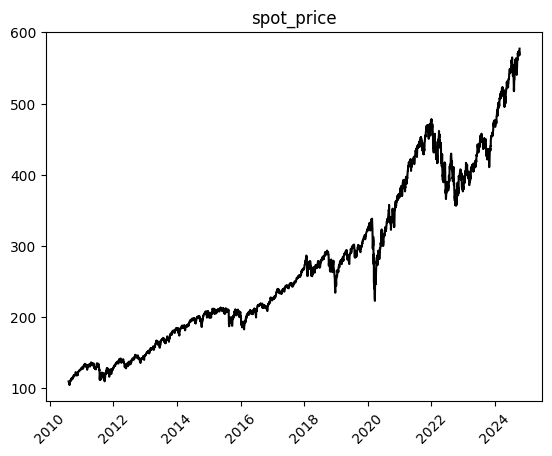

<Figure size 640x480 with 0 Axes>

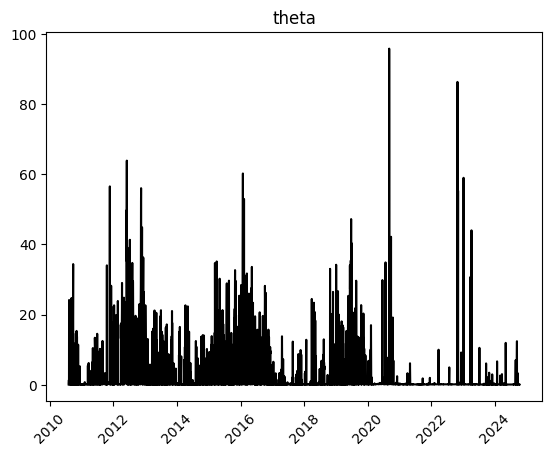

<Figure size 640x480 with 0 Axes>

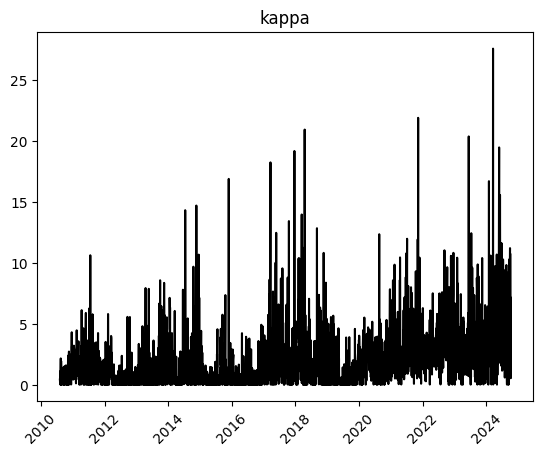

<Figure size 640x480 with 0 Axes>

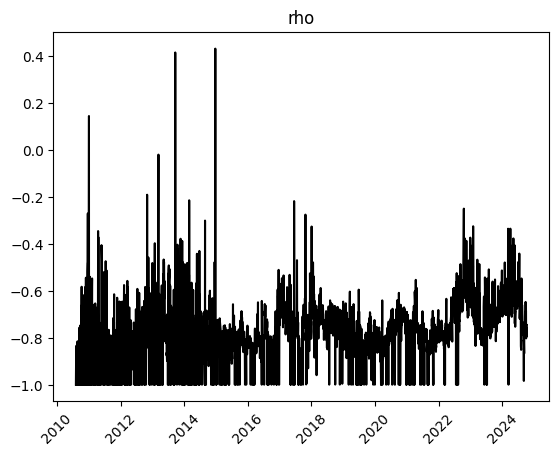

<Figure size 640x480 with 0 Axes>

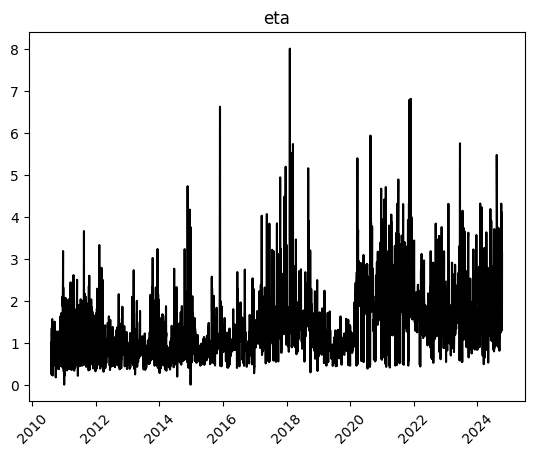

<Figure size 640x480 with 0 Axes>

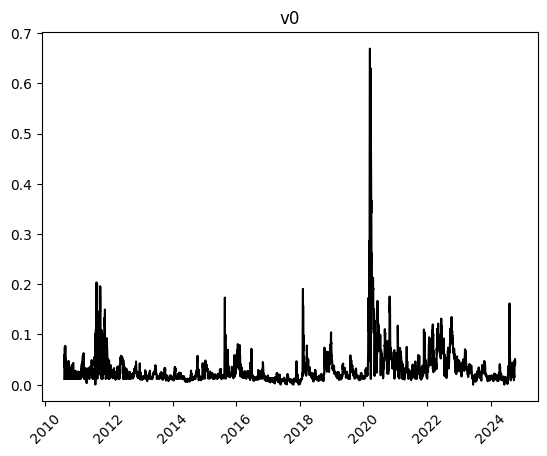


                    calculation_date   strike_price   market_price  \
count                        6307877 6307877.000000 6307877.000000   
mean   2018-11-16 11:06:55.965052672     282.459255      21.615832   
min              2010-08-06 00:00:00       5.000000       0.000000   
25%              2015-09-18 00:00:00     170.000000       0.110000   
50%              2019-10-31 00:00:00     261.000000       3.980000   
75%              2022-02-14 00:00:00     385.000000      21.040000   
max              2024-10-09 00:00:00    6400.000000    1314.180000   
std                              NaN     142.818810      43.464034   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 6307877.000000    6307877.000000 6307877.000000  6307877.000000   
mean        0.261752        112.597729     309.951492        0.040000   
min         0.000090         30.000000     105.230000        0.040000   
25%         0.151990         52.000000     206.020000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [3]:
calibration_keys = keys_df.copy().dropna(subset='calibration_key')
calibrations = []
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True)
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date')
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()
for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

In [4]:
calibrations.dtypes

strike_price        float64
w                    object
market_price        float64
volatility          float64
days_to_maturity      int64
spot_price          float64
risk_free_rate      float64
dividend_rate       float64
theta               float64
kappa               float64
eta                 float64
rho                 float64
v0                  float64
moneyness           float64
black_scholes       float64
heston_price        float64
relative_error      float64
dtype: object

In [5]:
problem = calibrations.copy()[calibrations['rho']>0].reset_index()
problem_dates = problem['calculation_date'].unique()
problem_dates

<DatetimeArray>
['2014-12-24 00:00:00', '2013-09-20 00:00:00', '2011-01-03 00:00:00']
Length: 3, dtype: datetime64[ns]

## cleaning invalid timestamps

# computed prices

# calibration error testing

[0]   Wednesday, 2014-12-24
                37       58       86       97       114      177      280  \
210.000000 0.121510 0.128370 0.132180 0.133240 0.133700 0.143000 0.159620   

                360      387  
210.000000 0.152150 0.155350  



[1]   Friday, 2013-09-20
                35       57       92       102      120      183      192  \
170.000000 0.123030 0.128370 0.147120 0.148490 0.149860 0.162820 0.163270   

                365  
170.000000 0.181260  



[2]   Monday, 2011-01-03
                47       75       87       103      166      257      270  \
130.000000 0.146350 0.152910 0.157330 0.162510 0.175320 0.183700 0.183240   

                348      383  
130.000000 0.184310 0.183700  





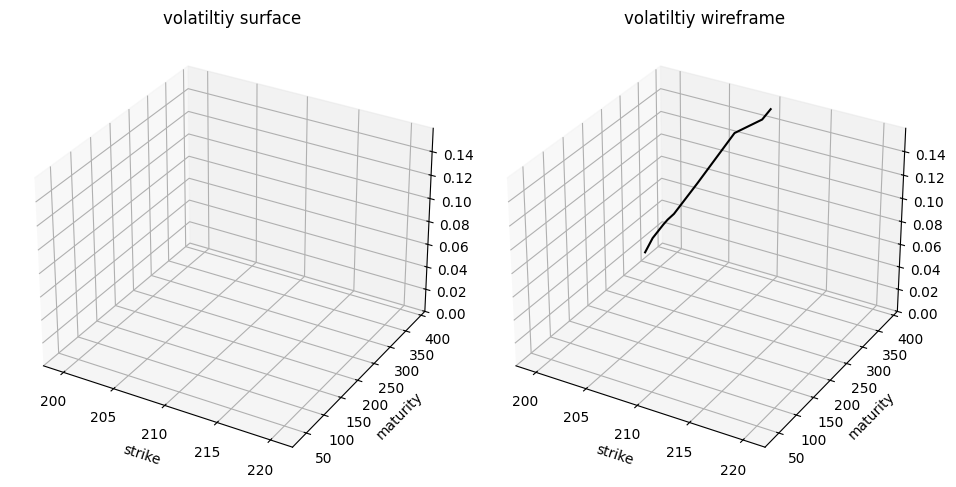

In [9]:
data=calibrations.copy()
data = data[data.index.isin(problem_dates)]
problem_dates = pd.to_datetime(problem_dates)
problem_keys = keys_df[keys_df['date'].isin(problem_dates)]

surfs = []
while True:
    try:
        store.open()
        j=0
        for i,row in problem_keys.iterrows():
            surf = store[row['surface_key']]
            surfs.append(surf)
            print(f"[{j}]   "+row['date'].strftime('%A, %Y-%m-%d'))
            print(surf)
            print('\n\n')
            j+=1
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for g in range(2):
            print(2-g)
    finally:
        store.close()

data = surfs[0]
T = data.columns.tolist()
K = data.index.tolist()

KK,TT = np.meshgrid(K,T)
VV = np.array(
        [[data.loc[k,t] for k in K] for t in T]
        )
fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(KK, TT, VV, rstride=1, cstride=1, cmap=cm.magma, linewidth=0.1)


ax1.set_zlim(0, float(max(data.values.flatten())))
ax1.set_title('volatiltiy surface')
ax1.set_xlabel('strike')
ax1.set_ylabel('maturity')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_wireframe(KK, TT, VV, rstride=1, cstride=1,color='black')
ax2.set_zlim(0, float(max(data.values.flatten())))
ax2.set_title('volatiltiy wireframe')
ax2.set_xlabel('strike')
ax2.set_ylabel('maturity')

plt.tight_layout()
plt.show()

## removal of problematic entries

In [7]:
problem_keys

,contract_key,raw_data_key,surface_key,calibration_key,priced_securities_key,date
2440,/date_2014_12_29/hottest_contracts,/date_2014_12_29/raw_data,/date_2014_12_24/surface,/date_2014_11_28/calibration,NaN,2014-12-24
2754,/date_2013_09_27/hottest_contracts,/date_2013_09_27/raw_data,/date_2013_09_20/surface,/date_2013_08_21/calibration,NaN,2013-09-20
3434,/date_2011_01_12/hottest_contracts,/date_2011_01_12/raw_data,/date_2011_01_03/surface,/date_2010_12_01/calibration,NaN,2011-01-03


In [10]:
store.open()
for i in problem_keys.index:
    actual_date_key_comp = problem_keys.loc[i,'raw_data_key'][:17]
    try:
        del store[f"{actual_date_key_comp}calibration"]
    else:
        pass
    try:
        
    del store[problem_keys.loc[i,'calibration_key']]
store.close()       

KeyError: 'No object named /date_2014_12_29/calibration in the file'